In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from scipy.optimize import minimize
from tqdm import tqdm
from collections import defaultdict

In [2]:
task_data = pd.read_csv('PD_data_choice.csv')

## BRL

### Model fitting

In [3]:
def pd_brl_loglikelihood(sub_data, beta_param, bias, gamma_pos, gamma_neg):
    """
    Bayesian Reinforcement Learning log-likelihood function for Iterative Prisoner's Dilemma
    
    Parameters:
    sub_data: DataFrame with subject data (80 rounds per subject)
    beta_param: softmax temperature parameter for the player
    bias: bias parameter
    gamma_pos: learning rate for cooperative outcomes
    gamma_neg: learning rate for defective outcomes
    
    Returns:
    bayes_ll: negative log-likelihood
    choice_probs: Fitted choice probabilities for each trial
    mews: Estimated mean probabilities of cooperating for each trial
    """
    
    # Read trial parameters
    trial = sub_data['round_number'].values
    p1_choice = sub_data['p1_choice'].values
    p2_choice = sub_data['p2_choice'].values
    
    # Number of trials
    num_trials = len(trial)
    
    # Initialize priors for each 'player type': uniform probability
    a_init = 1.01
    b_init = 1.01
    
    # Set alpha and beta for each 'player type'
    a = a_init
    b = b_init
    
    # Store mean beta distribution and log likelihood
    mew = np.zeros(num_trials)
    loglike = np.zeros(num_trials)
    choice_probs = np.zeros(num_trials)
    mews = np.zeros(num_trials)
    
    # Loop over trials
    for t in range(num_trials):
        # Beta distribution to compute chris's probability of cooperating
        mew[t] = a / (a + b)
        
        # Human choice probability
        if p1_choice[t] == 1:  # probability of cooperating
            choice_prob = np.exp(beta_param * mew[t]) / (np.exp(beta_param * mew[t]) + np.exp(beta_param * bias))
        else:  # probability of defecting
            choice_prob = 1 - np.exp(beta_param * mew[t]) / (np.exp(beta_param * mew[t]) + np.exp(beta_param * bias))
        
        # Update strategies based on partner's action
        if p2_choice[t] == 1:
            a += 1  # cooperate
        else:
            b += 1  # defect
        
        a_prev = a
        b_prev = b
        
        # Update parameters with learning rate
        a = a_prev * gamma_pos  # cooperate LR
        b = b_prev * gamma_neg  # defect LR
        
        # Get trial log-likelihood and other prediction data
        loglike[t] = np.log(choice_prob)
        if p1_choice[t] == 1:
            choice_probs[t] = choice_prob
        else:
            choice_probs[t] = 1 - choice_prob
        mews[t] = mew[t]
    
    # Return negative sum of log-likelihood
    bayes_ll = -np.sum(loglike)
    return bayes_ll, choice_probs, mews

In [ ]:
bounds = [(1, 20), (0.1, 1), (0.1, 1), (0.1, 1)]
    
# Initialize results dictionary
params = {
    'subjNum': [],
    'subjBetaParam': [],
    'subjBias': [],
    'subjGammaPos': [],
    'subjGammaNeg': [],
    'subjBayesLL': []
}

# Subject list
sub_list = task_data['ppt_number'].unique()

for sub_num in tqdm(sub_list, desc="Fitting subjects", unit="subject"):
    
    # Get subject data
    sub_data = task_data[task_data['ppt_number'] == sub_num].copy()
    
    # Remove NaNs
    sub_data = sub_data.dropna()
    
    # Set number of iterations/starting points
    n_iter = 20
    
    if not sub_data.empty:  # if we have data for subject to model
        
        results = []
        likelihoods = []
        
        for iteration in range(n_iter):
            # Random initial values
            np.random.seed()
            init_vals = [
                np.random.rand() * 20,                    # beta_param: 0-20
                (np.random.rand() + 0.1) * 0.9,         # bias: 0.1-1
                (np.random.rand() + 0.1) * 0.9,         # gamma_pos: 0.1-1
                (np.random.rand() + 0.1) * 0.9          # gamma_neg: 0.1-1
            ]
            
            # Optimize parameters
            def objective(x):
                return pd_brl_loglikelihood(sub_data, x[0], x[1], x[2], x[3])[0]
            
            try:
                result = minimize(objective, init_vals, bounds=bounds, method='L-BFGS-B')
                results.append(result.x)
                likelihoods.append(result.fun)
            except:
                # If optimization fails, skip this iteration
                continue
        
        if likelihoods:  # If we have valid results
            # Find minimum likelihood
            min_bayes_ll = min(likelihoods)
            best_idx = likelihoods.index(min_bayes_ll)
            
            # Save best fitting parameters
            best_params = results[best_idx]
            beta = best_params[0]
            bias = best_params[1]
            gamma_pos = best_params[2]
            gamma_neg = best_params[3]
            
            # Store results
            params['subjNum'].append(sub_num)
            params['subjBetaParam'].append(beta)
            params['subjBias'].append(bias)
            params['subjGammaPos'].append(gamma_pos)
            params['subjGammaNeg'].append(gamma_neg)
            params['subjBayesLL'].append(min_bayes_ll)
            
            # Save intermediate results
            with open('m1_PD_BRL.pkl', 'wb') as f:
                pickle.dump(params, f)

# Compute AIC
num_params = len(bounds)
params['subjAIC'] = [-2 * ll - 2 * num_params for ll in params['subjBayesLL']]

# Create results DataFrame
results_df = pd.DataFrame({
    'sub_num': params['subjNum'],
    'betaParam': params['subjBetaParam'],
    'bias': params['subjBias'],
    'gammaPos': params['subjGammaPos'],
    'gammaNeg': params['subjGammaNeg'],
    'BayesLL': params['subjBayesLL'],
    'AIC': params['subjAIC']
})

# Save to Excel file
results_df.to_csv('PD_BRL_fitting_results.csv', index=False)

print("Model fitting completed!")

Fitting subjects: 100%|██████████| 142/142 [01:50<00:00,  1.28subject/s]

Model fitting completed!


### Results analysis

In [4]:
results_df = pd.read_csv('PD_BRL_fitting_results.csv')
results_df.head()

,sub_num,betaParam,bias,gammaPos,gammaNeg,BayesLL,AIC
0,1,9.343734,0.478638,0.645417,0.619850,28.328629,-64.657258
1,3,20.000000,0.260063,0.808777,1.000000,9.750429,-27.500858
2,4,20.000000,0.276046,0.836880,1.000000,14.733745,-37.467490
3,5,20.000000,0.341111,0.687485,0.784389,9.503122,-27.006243
4,6,18.537097,0.100000,0.436827,0.955349,42.564273,-93.128547


In [5]:
# Define chirs caterogy
chirs_categoty  = []
groups = task_data.groupby('ppt_number')
for group in groups:
    group_data = group[1]

    chirs_behavior = tuple(group_data['chris_prob'].to_list())
    if chirs_behavior not in chirs_categoty:
        chirs_categoty.append(chirs_behavior)

# Define subject categoty based on chris behavior
subjects_category = defaultdict(list)
for group in groups:
    sub_num = group[0]
    group_data = group[1]

    chirs_behavior = tuple(group_data['chris_prob'].to_list())
    category_idx = chirs_categoty.index(chirs_behavior)
    subjects_category[category_idx].append(sub_num)


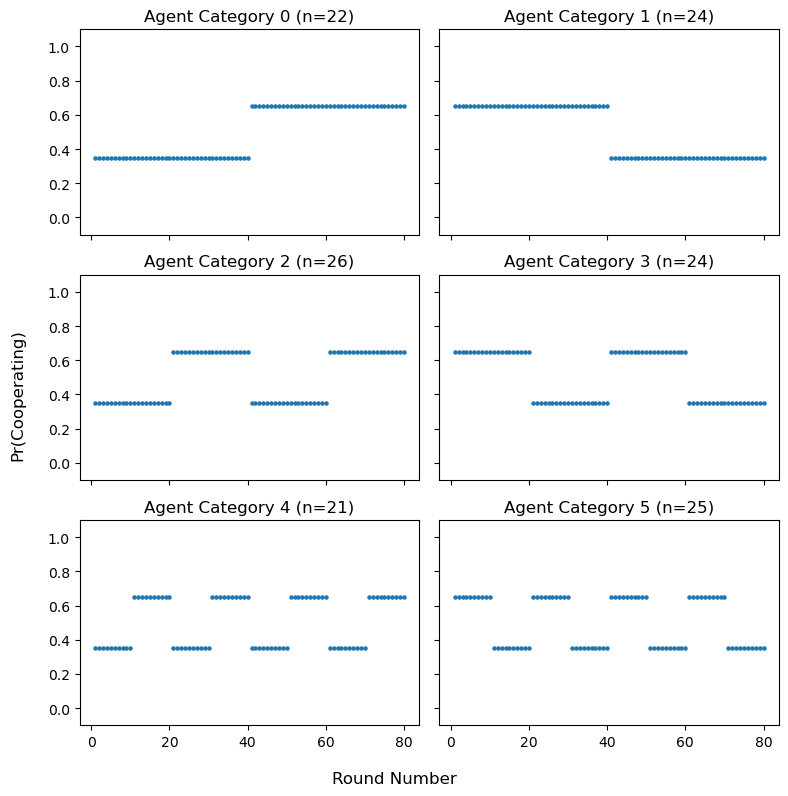

In [6]:
# Visalize chris category
fig, axs = plt.subplots(3, 2, figsize=(8, 8), sharex=True, sharey=True)
rounds = np.arange(1, 81)
for idx, ax in enumerate(axs.flatten()):
    if idx < len(chirs_categoty):
        ax.scatter(rounds, chirs_categoty[idx], s=5)
        ax.set_title(f'Agent Category {idx} (n={len(subjects_category[idx])})')
        ax.set_ylim(-0.1, 1.1)
    else:
        ax.axis('off')

fig.supxlabel('Round Number', fontsize=12)
fig.supylabel('Pr(Cooperating)', fontsize=12)

plt.tight_layout()
plt.show()

In [8]:
task_data.head()

,ppt_number,ppt_gender,condition,round_number,binary_classification,chris_prob,ppt_contrib,chris_contrib,ppt_RT,prediction_report,prediction_RT,chris_behavior,turing_test,ppt_payment,start_strategy,p1_choice,p2_choice
0,1,female,low_vol,1,False,0.35,20,20,3743.000,0.09,6695.0,neither,human,1.76,0,1,1
1,1,female,low_vol,2,False,0.35,20,0,1600.005,0.09,6695.0,neither,human,1.76,0,1,0
2,1,female,low_vol,3,False,0.35,0,0,1653.000,0.09,6695.0,neither,human,1.76,0,0,0
3,1,female,low_vol,4,False,0.35,0,20,1711.005,0.09,6695.0,neither,human,1.76,0,0,1
4,1,female,low_vol,5,False,0.35,20,0,1631.000,0.09,6695.0,neither,human,1.76,0,1,0


In [7]:
# Aggregate rounds into blocks of 10
block_size = 10
num_blocks = task_data['round_number'].max() // block_size
blocked_data = []
sub_list = task_data['ppt_number'].unique()

for sub_num in sub_list:
    sub_data = task_data[task_data['ppt_number'] == sub_num].copy()
    
    # Process each block
    for block in range(num_blocks):
        block_start = block * block_size + 1
        block_end = (block + 1) * block_size
        
        block_data = sub_data[(sub_data['round_number'] >= block_start) & (sub_data['round_number'] <= block_end)]
        
        if not block_data.empty:
            coop_rate = block_data['p1_choice'].mean()
            chris_coop_rate = block_data['p2_choice'].mean()
            subject_predict_chris_coop = block_data['prediction_report'].mean()
            
            blocked_data.append({
                'ppt_number': sub_num,
                'block_number': block + 1,
                'subject_coop_rate': coop_rate,
                'chris_coop_rate': chris_coop_rate,
                'subject_predict_chris_coop': subject_predict_chris_coop
            })

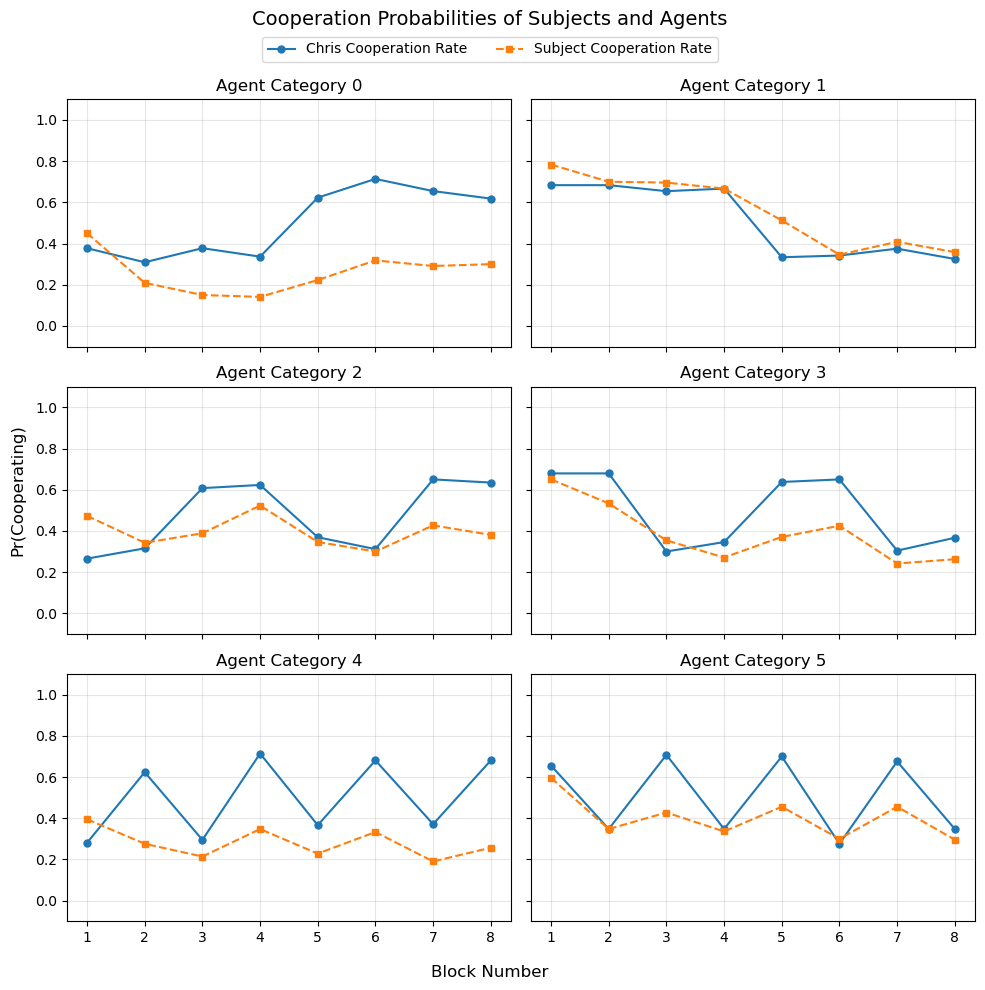

In [27]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)
rounds = np.arange(1, 81)

# Create handles for legend (will be created from first plot)
handles, labels = None, None

for idx, ax in enumerate(axs.flatten()):
    if idx < len(chirs_categoty):
        subjects = subjects_category[idx]
        chris_blocked_choice = defaultdict(list)
        subject_blocked_choice = defaultdict(list)
        for each in blocked_data:
            if each['ppt_number'] in subjects:
                chris_blocked_choice[each['block_number']].append(each['chris_coop_rate'])
                subject_blocked_choice[each['block_number']].append(each['subject_coop_rate'])

        blocks = sorted(chris_blocked_choice.keys())
        chris_blocked_choice = [np.mean(chris_blocked_choice[block]) for block in blocks]
        subject_blocked_choice = [np.mean(subject_blocked_choice[block]) for block in blocks]

        # Plot with markers
        line1 = ax.plot(blocks, chris_blocked_choice, marker='o', linestyle='-', 
                       label='Chris Cooperation Rate', markersize=5)
        line2 = ax.plot(blocks, subject_blocked_choice, marker='s', linestyle='--', 
                       label='Subject Cooperation Rate', markersize=5)
        
        # Get handles and labels from first plot
        if handles is None:
            handles, labels = ax.get_legend_handles_labels()
        
        ax.set_title(f'Agent Category {idx}')
        ax.set_ylim(-0.1, 1.1)
        ax.grid(True, alpha=0.3)
    else:
        ax.axis('off')

# Add single legend above the subplots
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.96), 
          frameon=True, fontsize=10)

fig.supxlabel('Block Number', fontsize=12)
fig.supylabel('Pr(Cooperating)', fontsize=12)
fig.suptitle('Cooperation Probabilities of Subjects and Agents', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for legend at top
plt.show()

In [9]:
# Get model prediction
fitted_params = pd.read_csv('PD_BRL_fitting_results.csv')
fitted_params.head()

,sub_num,betaParam,bias,gammaPos,gammaNeg,BayesLL,AIC
0,1,9.343734,0.478638,0.645417,0.619850,28.328629,-64.657258
1,3,20.000000,0.260063,0.808777,1.000000,9.750429,-27.500858
2,4,20.000000,0.276046,0.836880,1.000000,14.733745,-37.467490
3,5,20.000000,0.341111,0.687485,0.784389,9.503122,-27.006243
4,6,18.537097,0.100000,0.436827,0.955349,42.564273,-93.128547


In [14]:
brl_predictions = defaultdict(dict)
for _, row in fitted_params.iterrows():
    sub_num = row['sub_num']
    beta_param = row['betaParam']
    bias = row['bias']
    gamma_pos = row['gammaPos']
    gamma_neg = row['gammaNeg']
    
    sub_data = task_data[task_data['ppt_number'] == sub_num].copy()
    
    if not sub_data.empty:
        _, choice_probs, mews = pd_brl_loglikelihood(sub_data, beta_param, bias, gamma_pos, gamma_neg)
        
        brl_predictions[sub_num]['choice_probs'] = choice_probs
        brl_predictions[sub_num]['mews'] = mews

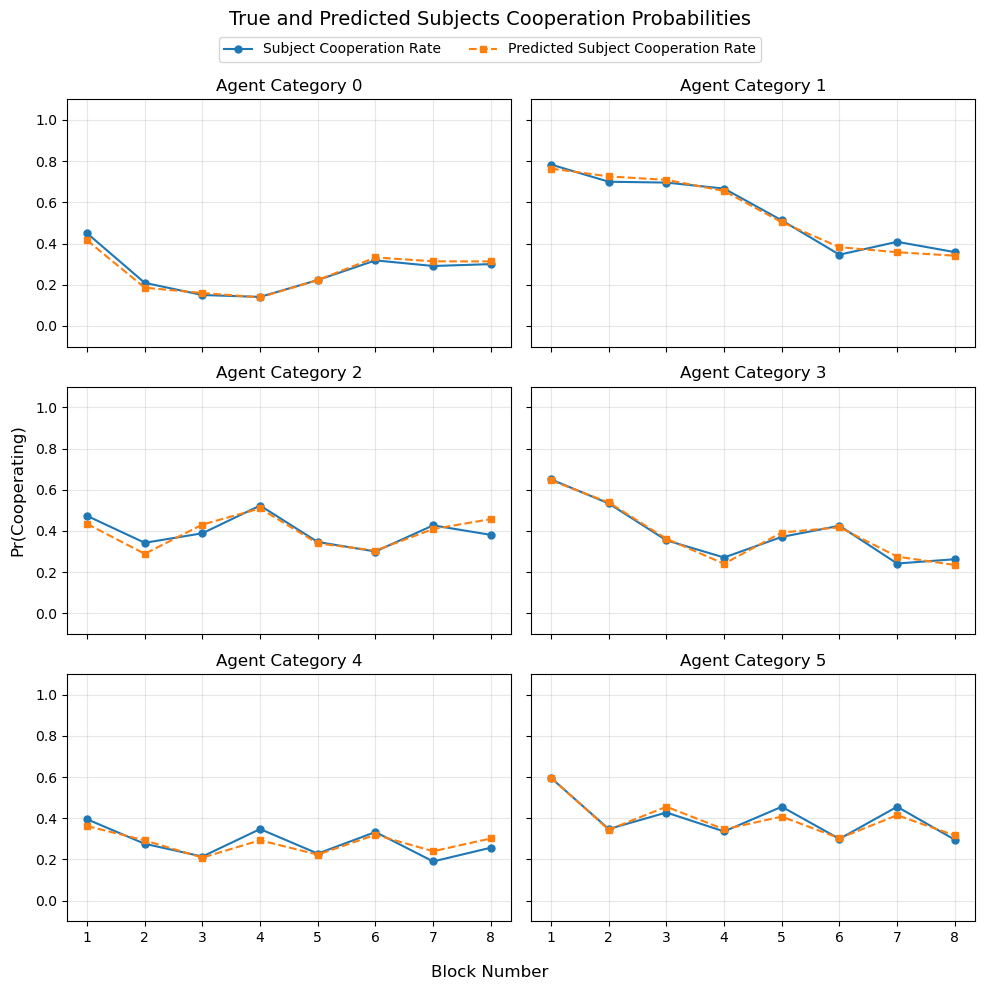

In [44]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)
rounds = np.arange(1, 81)

# Create handles for legend (will be created from first plot)
handles, labels = None, None

for idx, ax in enumerate(axs.flatten()):
    if idx < len(chirs_categoty):
        subjects = subjects_category[idx]
        subject_blocked_choice = defaultdict(list)
        for each in blocked_data:
            if each['ppt_number'] in subjects:
                subject_blocked_choice[each['block_number']].append(each['subject_coop_rate'])

        blocks = sorted(subject_blocked_choice.keys())
        subject_blocked_choice = [np.mean(subject_blocked_choice[block]) for block in blocks]

        # Get BRL predictions
        brl_blocked_choice = defaultdict(list)
        for sub, v in brl_predictions.items():
            if sub in subjects:
                choice_probs = v['choice_probs']
                # Aggregate into blocks
                for block in range(num_blocks):
                    block_start = block * block_size
                    block_end = (block + 1) * block_size
                    block_choice_probs = choice_probs[block_start:block_end]
                    mean_choice_prob = np.mean(block_choice_probs)
                    brl_blocked_choice[block + 1].append(mean_choice_prob)
        brl_blocked_choice = [np.mean(brl_blocked_choice[block]) for block in blocks]

        # Plot with markers
        line1 = ax.plot(blocks, subject_blocked_choice, marker='o', linestyle='-', 
                       label='Subject Cooperation Rate', markersize=5)
        line2 = ax.plot(blocks, brl_blocked_choice, marker='s', linestyle='--', 
                       label='Predicted Subject Cooperation Rate', markersize=5)
        
        # Get handles and labels from first plot
        if handles is None:
            handles, labels = ax.get_legend_handles_labels()
        
        ax.set_title(f'Agent Category {idx}')
        ax.set_ylim(-0.1, 1.1)
        ax.grid(True, alpha=0.3)
    else:
        ax.axis('off')

# Add single legend above the subplots
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.96), 
          frameon=True, fontsize=10)

fig.supxlabel('Block Number', fontsize=12)
fig.supylabel('Pr(Cooperating)', fontsize=12)
fig.suptitle('True and Predicted Subjects Cooperation Probabilities', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for legend at top
plt.show()

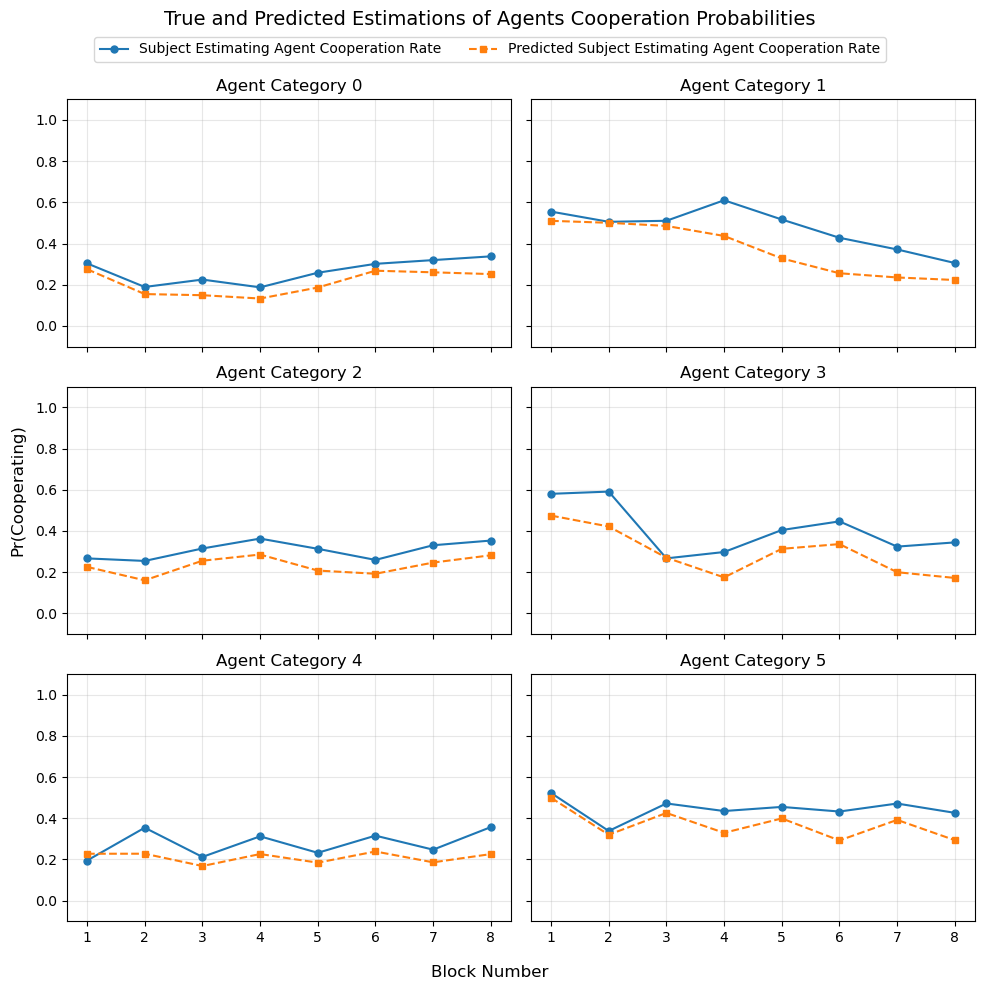

In [40]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)
rounds = np.arange(1, 81)

# Create handles for legend (will be created from first plot)
handles, labels = None, None

for idx, ax in enumerate(axs.flatten()):
    if idx < len(chirs_categoty):
        subjects = subjects_category[idx]
        subject_predict_choice = defaultdict(list)
        for each in blocked_data:
            if each['ppt_number'] in subjects:
                subject_predict_choice[each['block_number']].append(each['subject_predict_chris_coop'])

        blocks = sorted(subject_predict_choice.keys())
        subject_predict_choice = [np.mean(subject_predict_choice[block]) for block in blocks]

        # Get BRL predictions
        brl_mews = defaultdict(list)
        for sub, v in brl_predictions.items():
            if sub in subjects:
                mews = v['mews']
                # Aggregate into blocks
                for block in range(num_blocks):
                    block_start = block * block_size
                    block_end = (block + 1) * block_size
                    block_mews = mews[block_start:block_end]
                    mean_mews = np.mean(block_mews)
                    brl_mews[block + 1].append(mean_mews)
        brl_mews = [np.mean(brl_mews[block]) for block in blocks]

        # Plot with markers
        line1 = ax.plot(blocks, subject_predict_choice, marker='o', linestyle='-', 
                       label='Subject Estimating Agent Cooperation Rate', markersize=5)
        line2 = ax.plot(blocks, brl_mews, marker='s', linestyle='--', 
                       label='Predicted Subject Estimating Agent Cooperation Rate', markersize=5)
        
        # Get handles and labels from first plot
        if handles is None:
            handles, labels = ax.get_legend_handles_labels()
        
        ax.set_title(f'Agent Category {idx}')
        ax.set_ylim(-0.1, 1.1)
        ax.grid(True, alpha=0.3)
    else:
        ax.axis('off')

# Add single legend above the subplots
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.96), 
          frameon=True, fontsize=10)

fig.supxlabel('Block Number', fontsize=12)
fig.supylabel('Pr(Cooperating)', fontsize=12)
fig.suptitle('True and Predicted Estimations of Agents Cooperation Probabilities', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for legend at top
plt.show()

### Parameter distribution

gamma diff, gamma, AIC, mew diff

In [10]:
fitted_params.head()

,sub_num,betaParam,bias,gammaPos,gammaNeg,BayesLL,AIC
0,1,9.343734,0.478638,0.645417,0.619850,28.328629,-64.657258
1,3,20.000000,0.260063,0.808777,1.000000,9.750429,-27.500858
2,4,20.000000,0.276046,0.836880,1.000000,14.733745,-37.467490
3,5,20.000000,0.341111,0.687485,0.784389,9.503122,-27.006243
4,6,18.537097,0.100000,0.436827,0.955349,42.564273,-93.128547


In [11]:
gammas_pos = defaultdict(list)
gammas_neg = defaultdict(list)
gammas_diff = defaultdict(list)
aics = defaultdict(list)
for category, subjects in subjects_category.items():
    for sub in subjects:
        sub_params = fitted_params[fitted_params['sub_num'] == sub]
        if not sub_params.empty:
            gamma_pos = sub_params['gammaPos'].values[0]
            gamma_neg = sub_params['gammaNeg'].values[0]
            aic = sub_params['AIC'].values[0]
            
            gammas_pos[category].append(gamma_pos)
            gammas_neg[category].append(gamma_neg)
            gammas_diff[category].append(gamma_pos - gamma_neg)
            aics[category].append(aic)

/var/folders/vk/y0py541n5dz4n87sy_stcqf40000gn/T/ipykernel_28845/366169733.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[0, 0].boxplot(data_pos, labels=labels, patch_artist=True, widths=0.5)
/var/folders/vk/y0py541n5dz4n87sy_stcqf40000gn/T/ipykernel_28845/366169733.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[0, 1].boxplot(data_neg, labels=labels, patch_artist=True, widths=0.5)
/var/folders/vk/y0py541n5dz4n87sy_stcqf40000gn/T/ipykernel_28845/366169733.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = axes[1, 0].boxplot(data_diff, labels=labels, patch_artist=True, widths=0.

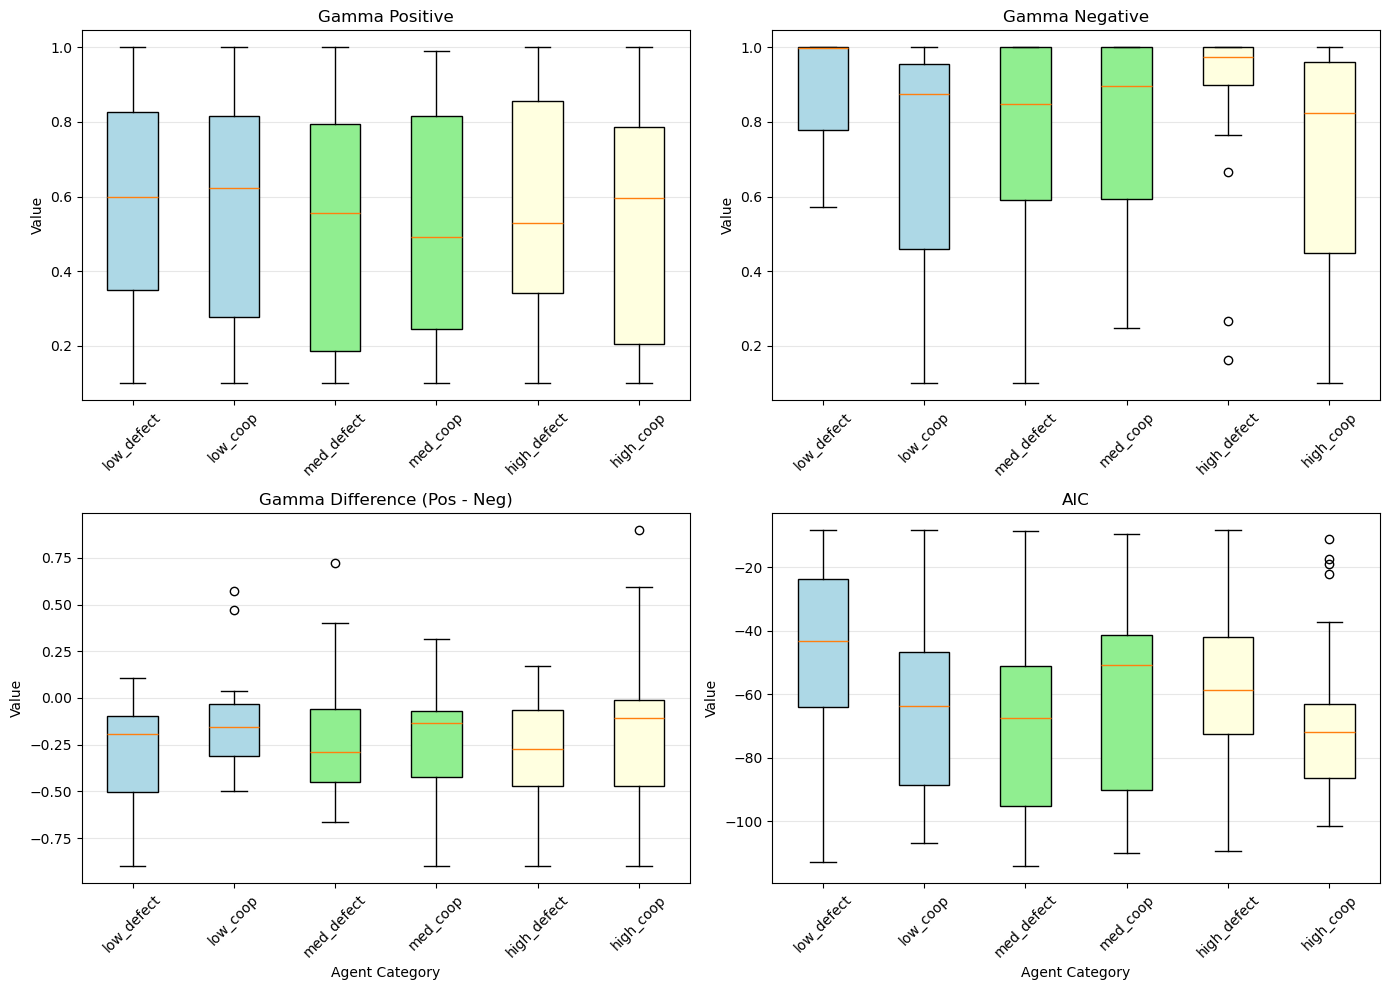

In [23]:
# Create subplots for multiple parameters
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
categories = sorted(gammas_pos.keys())

# Map category numbers to descriptive labels
category_labels = {
    0: 'low_defect',
    1: 'low_coop',
    2: 'med_defect',
    3: 'med_coop',
    4: 'high_defect',
    5: 'high_coop'
}

# Create labels list
labels = [category_labels.get(cat, f'Cat_{cat}') for cat in categories]

# Define colors for each group (low, med, high)
colors = ['lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'lightyellow', 'lightyellow']

# Gamma Positive
data_pos = [gammas_pos[cat] for cat in categories]
bp1 = axes[0, 0].boxplot(data_pos, labels=labels, patch_artist=True, widths=0.5)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 0].set_title('Gamma Positive')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].tick_params(axis='x', rotation=45)

# Gamma Negative
data_neg = [gammas_neg[cat] for cat in categories]
bp2 = axes[0, 1].boxplot(data_neg, labels=labels, patch_artist=True, widths=0.5)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 1].set_title('Gamma Negative')
axes[0, 1].set_ylabel('Value')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].tick_params(axis='x', rotation=45)

# Gamma Difference
data_diff = [gammas_diff[cat] for cat in categories]
bp3 = axes[1, 0].boxplot(data_diff, labels=labels, patch_artist=True, widths=0.5)
for patch, color in zip(bp3['boxes'], colors):
    patch.set_facecolor(color)
axes[1, 0].set_title('Gamma Difference (Pos - Neg)')
axes[1, 0].set_xlabel('Agent Category')
axes[1, 0].set_ylabel('Value')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].tick_params(axis='x', rotation=45)

# AIC
data_aic = [aics[cat] for cat in categories]
bp4 = axes[1, 1].boxplot(data_aic, labels=labels, patch_artist=True, widths=0.5)
for patch, color in zip(bp4['boxes'], colors):
    patch.set_facecolor(color)
axes[1, 1].set_title('AIC')
axes[1, 1].set_xlabel('Agent Category')
axes[1, 1].set_ylabel('Value')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

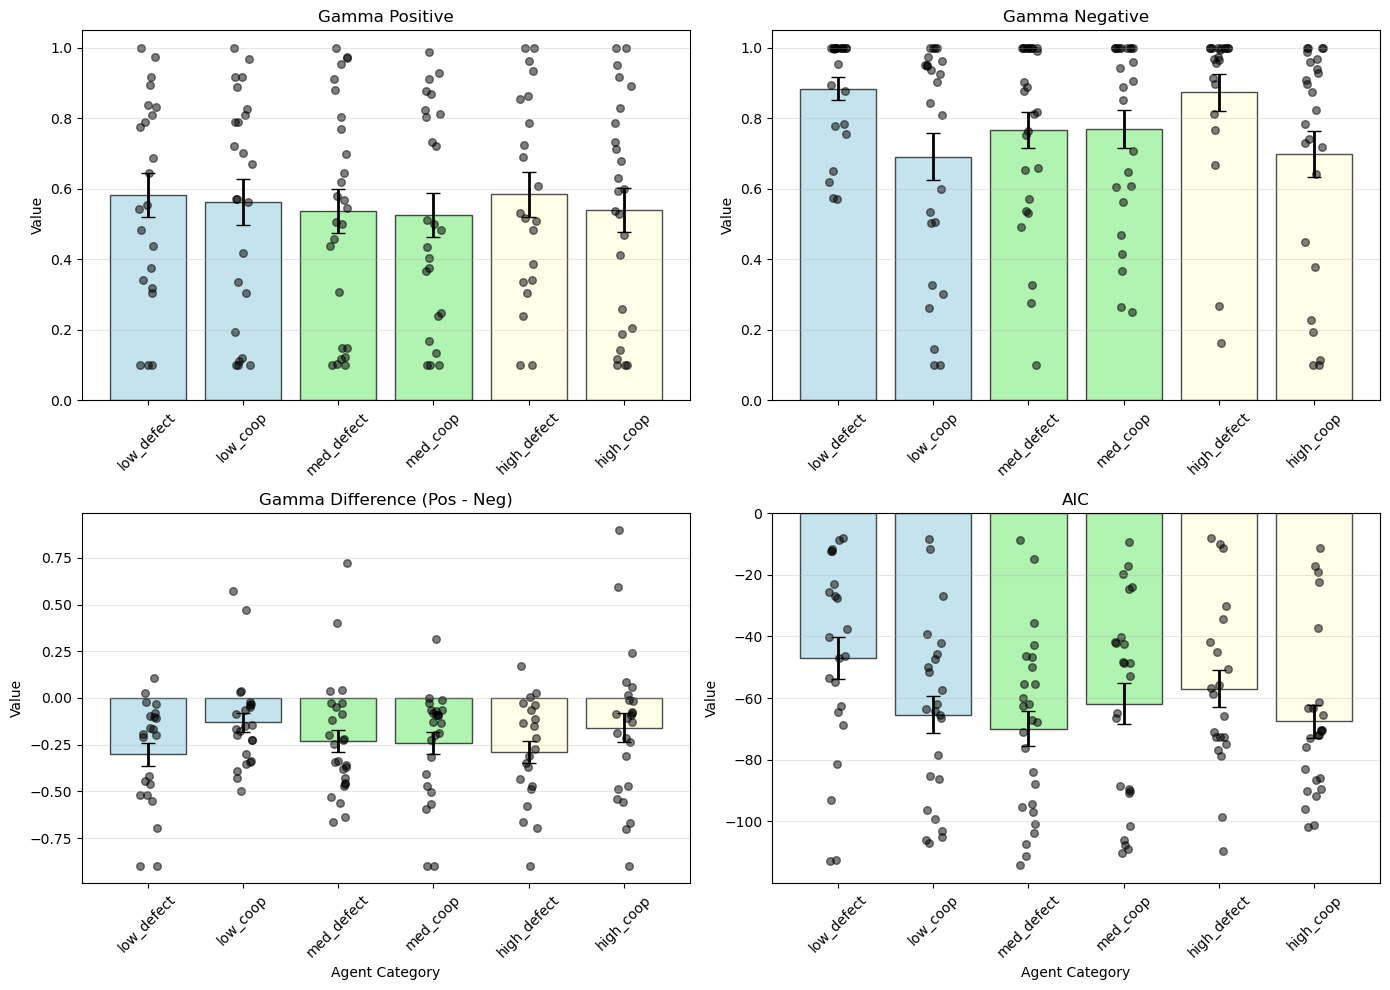

In [23]:
def bar_with_points(ax, data_dict, categories, labels, colors,
                    title, ylabel=None, xlabel=None):
    # prepare data
    data = [np.array(data_dict[cat]) for cat in categories]
    means = [d.mean() for d in data]
    sems  = [d.std(ddof=1) / np.sqrt(len(d)) for d in data]

    x = np.arange(len(categories))

    # bars (means)
    ax.bar(x, means, color=colors, edgecolor='black', alpha=0.7)

    # error bars (SEM)
    ax.errorbar(x, means, yerr=sems,
                fmt='none', ecolor='black', elinewidth=2, capsize=5)

    # scatter points
    for i, d in enumerate(data):
        jitter = (np.random.rand(len(d)) - 0.5) * 0.2
        ax.scatter(np.full(len(d), x[i]) + jitter,
                   d,
                   color='black', alpha=0.5, s=30)

    # labels etc.
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_title(title)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    ax.grid(True, alpha=0.3, axis='y')
    # If you want a zero-reference line, uncomment the next line:
    # ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)


# -------- main plotting code --------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
categories = sorted(gammas_pos.keys())

category_labels = {
    0: 'low_defect',
    1: 'low_coop',
    2: 'med_defect',
    3: 'med_coop',
    4: 'high_defect',
    5: 'high_coop'
}
labels = [category_labels.get(cat, f'Cat_{cat}') for cat in categories]

colors = ['lightblue', 'lightblue', 'lightgreen', 'lightgreen',
          'lightyellow', 'lightyellow']

# Gamma Positive
bar_with_points(axes[0, 0], gammas_pos, categories, labels, colors,
                title='Gamma Positive', ylabel='Value')

# Gamma Negative
bar_with_points(axes[0, 1], gammas_neg, categories, labels, colors,
                title='Gamma Negative', ylabel='Value')

# Gamma Difference
bar_with_points(axes[1, 0], gammas_diff, categories, labels, colors,
                title='Gamma Difference (Pos - Neg)',
                ylabel='Value', xlabel='Agent Category')

# AIC
bar_with_points(axes[1, 1], aics, categories, labels, colors,
                title='AIC', ylabel='Value', xlabel='Agent Category')

plt.tight_layout()
plt.show()

In [28]:
blocked_data[0]

{'ppt_number': np.int64(1),
 'block_number': 1,
 'subject_coop_rate': np.float64(0.3),
 'chris_coop_rate': np.float64(0.5),
 'subject_predict_chris_coop': np.float64(0.09)}

In [21]:
diff_mews = defaultdict(list)
for category, subjects in subjects_category.items():
    for each in blocked_data:
        if each['ppt_number'] in subjects:
            block_start = block * block_size
            block_end = (block + 1) * block_size
            subject_predict_mew = brl_predictions[each['ppt_number']]['mews'][block_start:block_end][0]
            
            diff_mews[category].append(each['subject_predict_chris_coop']-subject_predict_mew)

/var/folders/vk/y0py541n5dz4n87sy_stcqf40000gn/T/ipykernel_28845/3239666626.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, patch_artist=True, widths=0.5)


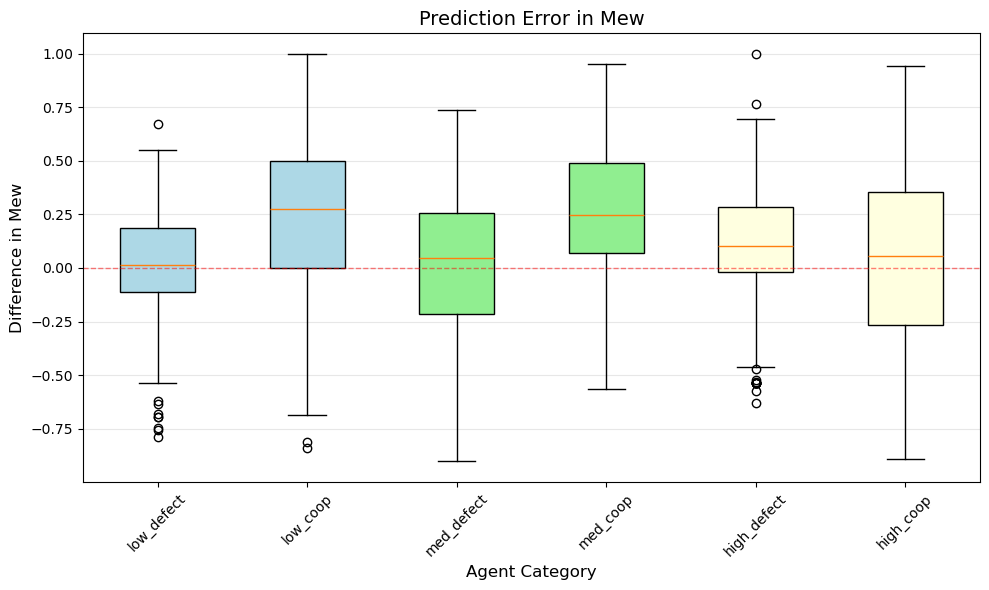

In [36]:
# Create box plot for diff_mews
fig, ax = plt.subplots(figsize=(10, 6))
categories = sorted(diff_mews.keys())

# Map category numbers to descriptive labels
category_labels = {
    0: 'low_defect',
    1: 'low_coop',
    2: 'med_defect',
    3: 'med_coop',
    4: 'high_defect',
    5: 'high_coop'
}

# Create labels list
labels = [category_labels.get(cat, f'Cat_{cat}') for cat in categories]

# Define colors for each group (low, med, high)
colors = ['lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'lightyellow', 'lightyellow']

# Prepare data
data = [diff_mews[cat] for cat in categories]

# Create box plot
bp = ax.boxplot(data, labels=labels, patch_artist=True, widths=0.5)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Customize plot
ax.set_xlabel('Agent Category', fontsize=12)
ax.set_ylabel('Difference in Mew', fontsize=12)
ax.set_title('Prediction Error in Mew', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')
ax.tick_params(axis='x', rotation=45)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

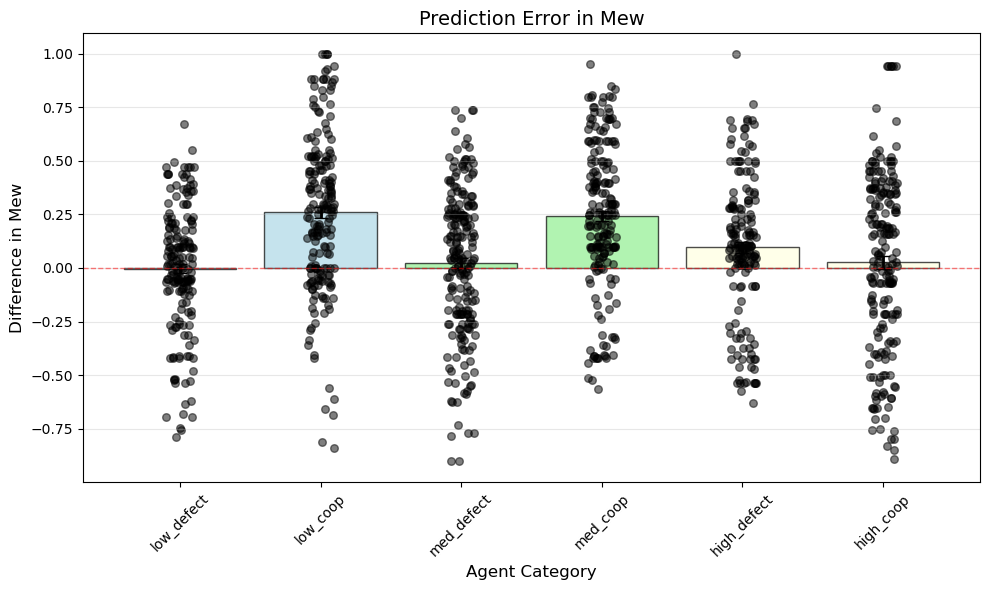

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
categories = sorted(diff_mews.keys())

# Map category numbers to descriptive labels
category_labels = {
    0: 'low_defect',
    1: 'low_coop',
    2: 'med_defect',
    3: 'med_coop',
    4: 'high_defect',
    5: 'high_coop'
}

labels = [category_labels.get(cat, f'Cat_{cat}') for cat in categories]

# Box colors replaced by bar colors
colors = ['lightblue', 'lightblue', 'lightgreen', 'lightgreen', 'lightyellow', 'lightyellow']

# Prepare data
data = [np.array(diff_mews[cat]) for cat in categories]
means = [d.mean() for d in data]
sems = [d.std(ddof=1) / np.sqrt(len(d)) for d in data]

x = np.arange(len(categories))

# ---- Bars (means) ----
bars = ax.bar(x, means, color=colors, edgecolor='black', alpha=0.7)

# ---- Error bars (SEM) ----
ax.errorbar(
    x,
    means,
    yerr=sems,
    fmt='none',
    ecolor='black',
    elinewidth=2,
    capsize=5
)

# ---- Scatter points ----
for i, d in enumerate(data):
    jitter = (np.random.rand(len(d)) - 0.5) * 0.2   # horizontal jitter
    ax.scatter(
        np.full(len(d), x[i]) + jitter,
        d,
        color='black',
        alpha=0.5,
        s=30
    )

# ---- Decorations ----
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_xlabel('Agent Category', fontsize=12)
ax.set_ylabel('Difference in Mew', fontsize=12)
ax.set_title('Prediction Error in Mew', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# Zero reference line
ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()
